Importing Libraries

In [1]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.6 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


Data Preprocessing

In [5]:
import pandas as pd

df = pd.read_csv("/content/carprices.csv")

In [6]:
df.isnull().sum()

,0
year,0
make,10301
model,10399
trim,10651
body,13195
transmission,65352
vin,4
state,0
condition,11820
odometer,94


In [7]:
df['transmission'].fillna('automatic', inplace=True)

In [8]:
df = df.dropna(subset=['vin', 'state','sellingprice','saledate','make', 'model', 'trim','body','condition','odometer','color','interior','mmr'])

In [9]:
# Select categorical columns
categorical_columns = ['make','model','trim','body','transmission','vin','state','color','interior','seller','saledate']

In [10]:
from category_encoders import TargetEncoder
# Create a copy of the dataframe
df_encoded = df.copy()

# Apply Target Encoding
encoder = TargetEncoder(cols=categorical_columns)
df_encoded[categorical_columns] = encoder.fit_transform(df[categorical_columns], df['mmr'])


In [11]:
# Compute the correlation matrix
correlation_matrix = df_encoded.corr(method='pearson')

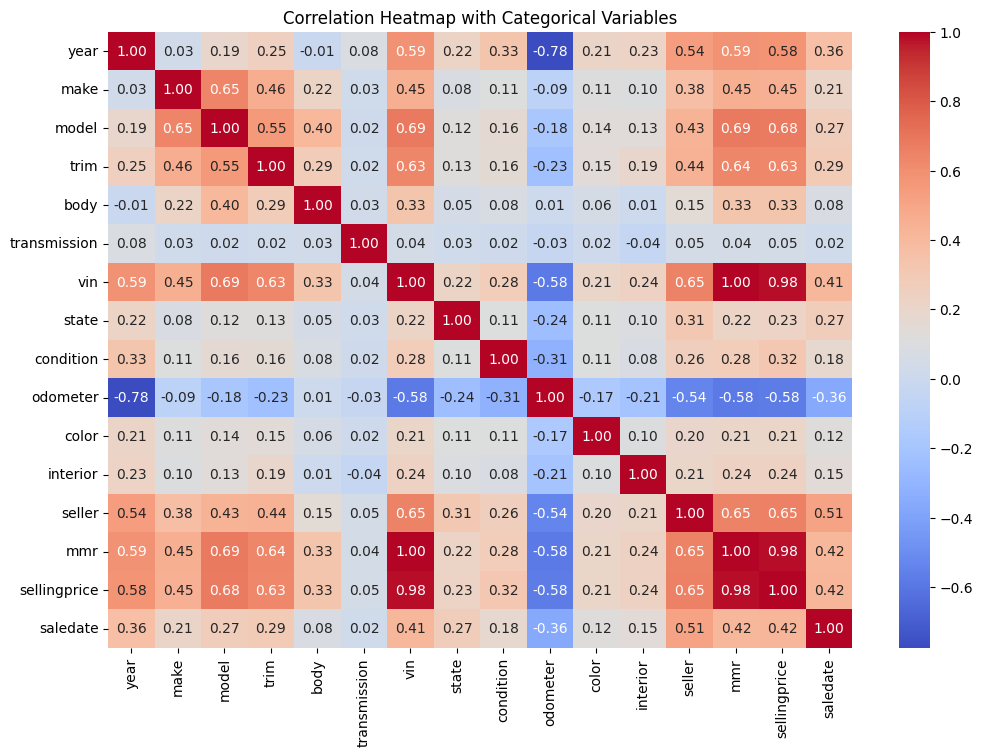

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap with Categorical Variables")
plt.show()


In [13]:
#list and drop columns that are less related to the target based on my judgement
cols_to_drop = ['transmission','color','interior','state','sellingprice','saledate','vin']

#at the same time rename the columns so they are understandable.
df = df.drop(columns = cols_to_drop).rename(columns = {'year':'manufacture_year','make':'brand','model':'specific_model','trim':'additional_designation','mmr':'estimated_value'})



In [14]:
df.head()

,manufacture_year,brand,specific_model,additional_designation,body,condition,odometer,seller,estimated_value
0,2015,Kia,Sorento,LX,SUV,5.0,16639.0,kia motors america inc,20500.0
1,2015,Kia,Sorento,LX,SUV,5.0,9393.0,kia motors america inc,20800.0
2,2014,BMW,3 Series,328i SULEV,Sedan,45.0,1331.0,financial services remarketing (lease),31900.0
3,2015,Volvo,S60,T5,Sedan,41.0,14282.0,volvo na rep/world omni,27500.0
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,43.0,2641.0,financial services remarketing (lease),66000.0


Encoding

In [15]:
#encoding
import category_encoders as ce

target_variable = 'estimated_value'  # Replace with your actual target variable name

target_encoder_trim = ce.TargetEncoder(cols=['additional_designation'])
df['additional_designation'] = target_encoder_trim.fit_transform(df['additional_designation'], df[target_variable])

target_encoder_seller = ce.TargetEncoder(cols=['seller'])
df['seller'] = target_encoder_seller.fit_transform(df['seller'], df[target_variable])

target_encoder_model = ce.TargetEncoder(cols=['specific_model'])
df['specific_model'] = target_encoder_model.fit_transform(df['specific_model'], df[target_variable])

target_encoder_model = ce.TargetEncoder(cols=['brand'])
df['brand'] = target_encoder_model.fit_transform(df['brand'], df[target_variable])

target_encoder_model = ce.TargetEncoder(cols=['body'])
df['body'] = target_encoder_model.fit_transform(df['body'], df[target_variable])

In [16]:
df.head()

,manufacture_year,brand,specific_model,additional_designation,body,condition,odometer,seller,estimated_value
0,2015,12010.749664,14794.995552,10532.394677,16260.868169,5.0,16639.0,16078.020436,20500.0
1,2015,12010.749664,14794.995552,10532.394677,16260.868169,5.0,9393.0,16078.020436,20800.0
2,2014,21511.459782,17090.538097,26288.607375,11891.745458,45.0,1331.0,28579.414621,31900.0
3,2015,11796.527012,13941.785080,16653.360371,11891.745458,41.0,14282.0,26000.901804,27500.0
4,2014,21511.459782,56189.554436,36014.403974,11891.745458,43.0,2641.0,28579.414621,66000.0


In [17]:
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 7


In [18]:
#dropping duplicates
df.drop_duplicates(inplace=True)

In [19]:
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 0


In [20]:
#Handling outliers
Q1 = df['estimated_value'].quantile(0.25)
Q3 = df['estimated_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['estimated_value'] < lower_bound) | (df['estimated_value'] > upper_bound)]

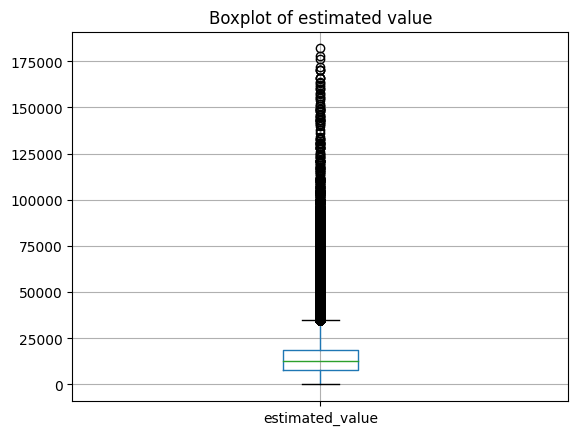

In [21]:
df[['estimated_value']].boxplot()
plt.title('Boxplot of estimated value')
plt.show()

In [22]:
df = df[(df['estimated_value'] >= lower_bound) & (df['estimated_value'] <= upper_bound)]


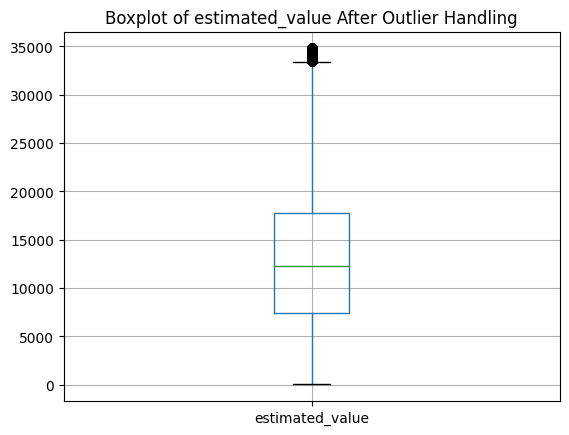

In [31]:
df[['estimated_value']].boxplot()
plt.title('Boxplot of estimated_value After Outlier Handling')
plt.show()

Train the model

In [24]:
#Test Train Splitting
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (y)
X = df.drop('estimated_value', axis=1)
y = df['estimated_value']

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [25]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)


LinearRegression()

Evaluate the model

In [27]:
# Assuming 'model' is your trained model
# The values you provided are assumed to be features for a single sample

X_new = [[2014, 12261.906847, 17180.327869, 13781.803320,
          21720.824602, 42.0, 35461.0, 9454.833236]]  # New data point

# Make the prediction
y_pred = model.predict(X_new)

# Output the predicted value
print("Predicted value:", y_pred)


Predicted value: [19890.07012239]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [30]:
from sklearn.metrics import r2_score,mean_squared_error

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the R-squared score
accuracy = r2_score(y_test, y_pred)

#calculate the mean squared value
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared Score: {accuracy}')
print(f"Mean Squared Error: {mse}")

R-squared Score: 0.8173744918565315
Mean Squared Error: 10573661.773812598
